# Cluster Evaluation

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

/mnt/rao/home/chenhg/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.4


/mnt/rao/home/chenhg/anaconda3/envs/scE2TM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/rao/home/chenhg/anaconda3/envs/scE2TM/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


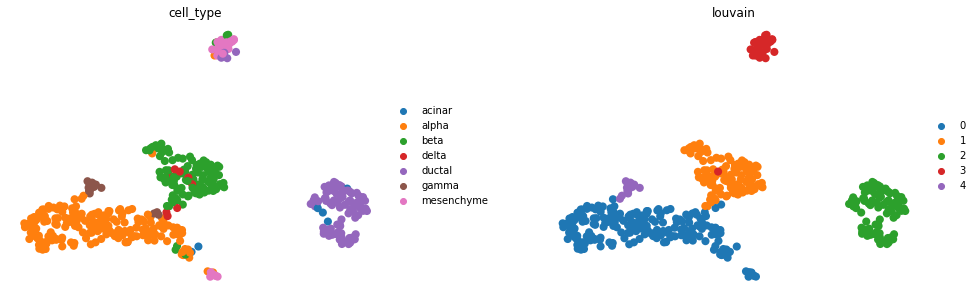

scE2TM   Adjusted_rand_score   0.8337700627920165   Adjusted_mutual_info_score   0.7719388423860872


In [2]:
dataname = 'Wang'
adata = sc.AnnData(pd.read_csv('../output/'+dataname+'/'+dataname+'_embedding.csv',sep=',',index_col=0))
label = pd.read_csv('../data/'+dataname+'_cell_anno.csv',sep=',',index_col=0)
adata.obs['cell_type'] = list(label[dataname.lower()+"@colData$cell_type1"])#label.values

sc.pp.pca(adata)
sc.pp.neighbors(adata,use_rep='X')
maxn = 2
minn= 0
list_value = []
for x in  range(minn, maxn*10):
    sc.tl.louvain(adata,resolution=x/10.0,random_state=0)
    list_value.append(adjusted_rand_score(adata.obs['cell_type'],adata.obs['louvain']))
sc.tl.louvain(adata,resolution=list_value.index(max(list_value))*0.1,random_state=0)
print(list_value.index(max(list_value))*0.1)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["cell_type","louvain"],
    wspace = 0.3,
    frameon=False,
    #save = "scE2TM_cluster_"+dataname+".pdf"
)
print("scE2TM   Adjusted_rand_score   "+str(adjusted_rand_score(adata.obs['cell_type'],adata.obs['louvain']))+"   Adjusted_mutual_info_score   "+str(adjusted_mutual_info_score(adata.obs['cell_type'],adata.obs['louvain'])))

# Interpretable Evaluation

In [3]:
import pandas as pd
import gseapy as gp
import numpy as np
kegg = gp.read_gmt(path="../data/c5.all.v2023.2.Hs.symbols.gmt") 
gene_set = []
cell_gene = []
for value in kegg.values():
    gene_set.extend(value)
    cell_gene.append(value)
gene_set = list(set(gene_set))
dicts_gene_index = {}
for index, value in enumerate(gene_set):
    dicts_gene_index[value] = index
bg_data = np.zeros((len(kegg),len(gene_set)))
for index, values in enumerate(kegg.values()):
    for value in values:
        bg_data[index][dicts_gene_index[value]] = 1

In [4]:
data = pd.read_csv('../output/'+dataname+'/'+dataname+'_tg.csv',sep=',',index_col=0)
data2 = pd.read_csv('../data/'+dataname+'_HIGHPRE_5000.csv',sep=',',index_col=0)
data.columns = data2.columns
data = data.T

## TC

In [5]:
def compute_coherence(cell_gene, topic_gene, N, dicts_gene_tran):
    # print('computing coherence ...')    
    topic_size, gene_size = np.shape(topic_gene)
    cell_size = np.shape(cell_gene)[0]
    # find top genes'index of each topic
    topic_list = []
    for topic_idx in range(topic_size):
        top_gene_idx = np.argpartition(topic_gene[topic_idx, :], -N)[-N:]
        topic_list.append(top_gene_idx)
    #print(topic_list)
    # compute coherence of each topic
    sum_coherence_score = 0.0
    for i in range(topic_size):
        gene_array = topic_list[i]
        sum_score = 0.0
        for n in range(N):
            if gene_array[n] in dicts_gene_tran:
                flag_n = cell_gene[:, dicts_gene_tran[gene_array[n]]] > 0
                p_n = np.sum(flag_n) / cell_size
                for l in range(n + 1, N):
                    if gene_array[l] in dicts_gene_tran:
                        flag_l = cell_gene[:, dicts_gene_tran[gene_array[l]]] > 0
                        p_l = np.sum(flag_l)
                        p_nl = np.sum(flag_n * flag_l)
                        if p_n * p_l * p_nl > 0:
                            p_l = p_l / cell_size
                            p_nl = p_nl / cell_size
                            sum_score += np.log(p_nl / (p_l * p_n)) / -np.log(p_nl)
        sum_coherence_score += sum_score * (2 / (N * N - N))
    sum_coherence_score = sum_coherence_score / topic_size
    return sum_coherence_score

dicts_gene_tran = {}
for index, value in enumerate(data.index):
    if value in dicts_gene_index:
        dicts_gene_tran[index] = dicts_gene_index[value]

TC = compute_coherence(bg_data, data.T.values, 10, dicts_gene_tran)

print(f"===>TC_T{10}: {TC:.5f}")

===>TC_T10: 0.11070


## TD

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
def TD_eva(texts):
    K = len(texts)
    T = len(texts[0].split())
    vectorizer = CountVectorizer()
    counter = vectorizer.fit_transform(texts).toarray()
    TF = counter.sum(axis=0)
    print(counter)
    TD = (TF == 1).sum() / (K * T)
    return TD

def get_topic_diversity(beta, topk):
    num_topics = beta.shape[0]
    list_w = np.zeros((num_topics, topk))
    for k in range(num_topics):
        idx = beta[k,:].argsort()[-topk:][::-1]
        list_w[k,:] = idx
    n_unique = len(np.unique(list_w))
    TD = n_unique / (topk * num_topics)
    print('Topic diveristy is: {}'.format(TD))

def ext_topic_genes(beta, vocab, num_top_gene):
    topic_str_list = list()
    for i, topic_dist in enumerate(beta):
        topic_genes = np.array(vocab)[np.argsort(topic_dist)][:-(num_top_gene + 1):-1]
        topic_str = ' '.join(topic_genes)
        topic_str_list.append(topic_str)
    return topic_str_list
topic_str_list = ext_topic_genes(data.T.values, data.index, 10)
TD = TD_eva(topic_str_list)
print(f"===>TD_T{10}: {TD:.5f}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
===>TD_T10: 0.70400


## IA

In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
print(purity_score(adata.obs['cell_type'],np.argmax(adata.X, axis=1)))

0.8927789934354485
